# 2. Model Dojo

In short, this notebook dedicated for SRCNN models training phase.

In [27]:
# Importing Packages
import os
import tensorflow
import numpy
from glob import glob
from tensorflow.keras import Model
from tensorflow.keras.layers import ReLU, Conv2D, Input
from tensorflow.keras.optimizers import Adam

### 2.1 Taking Data to be ready 

Currently I'm only have a low amount of training data set. Hence I will only make sure the code is working properly right now and saving the actual training process later. So, I will kind of using all the datasets to be trained of.

BATCH_SIZE will determine the number of data trained on every iterations. 

In [28]:
class PatchesDataset(tensorflow.keras.utils.Sequence):
    def __init__(self, batch_size, *args, **kwargs):
        self.batch_size = batch_size
        self.input = [*glob('../resources/np_image_input/*.np.npy')]
        self.output = [*glob('../resources/np_image_output/*.np.npy')]
        self.input.sort()
        self.output.sort()
        self.total_data = len(self.input)

    def __len__(self):
        # returns the number of batches
        return int(self.total_data / self.batch_size)

    def __getitem__(self, index):
        # returns one batch
        indices = self.random_indices()
        input = numpy.array([numpy.load(self.input[idx]) for idx in indices])
        output = numpy.array([numpy.load(self.output[idx]) for idx in indices])
        return input, output

    def random_indices(self):
        return numpy.random.choice(list(range(self.total_data)), self.batch_size, p=numpy.ones(self.total_data)/self.total_data)

### 2.2 Model Definition

I can't explain why is this like this... Unfortunately...

in short, this step will create a model, create an optimization through it, and create model summary

Dzlab said *"The architecture of the SRCNN model is very simple, it has only convolutional layers, one to downsize the input and extract image features and a later one to upside to generate the output image. The following helper function is used to create an instance of the model."*

In [29]:
def create_model(height, width, depth):
    input = Input(shape=(height, width, depth))
    x = Conv2D(filters=64, kernel_size=(9, 9), kernel_initializer='he_normal')(input)
    x = ReLU()(x)
    x = Conv2D(filters=32, kernel_size=(1, 1), kernel_initializer='he_normal')(x)
    x = ReLU()(x)
    output = Conv2D(filters=depth, kernel_size=(5, 5), kernel_initializer='he_normal')(x)
    return Model(input, output)

This part is taking Model Optimization. 

In [30]:
EPOCHS = 12
INPUT_DIM = 33 # This came from the 1.data_processing.ipynb
optimizer = Adam(learning_rate = 1e-3, decay = 1e-3 / EPOCHS)
model = create_model(INPUT_DIM, INPUT_DIM, 3)
model.compile(loss = 'mse', optimizer = optimizer)

In [31]:
# See model summary
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 33, 33, 3)]       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 25, 25, 64)        15616     
                                                                 
 re_lu_2 (ReLU)              (None, 25, 25, 64)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 25, 25, 32)        2080      
                                                                 
 re_lu_3 (ReLU)              (None, 25, 25, 32)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 21, 21, 3)         2403      
                                                                 
Total params: 20,099
Trainable params: 20,099
Non-trainable

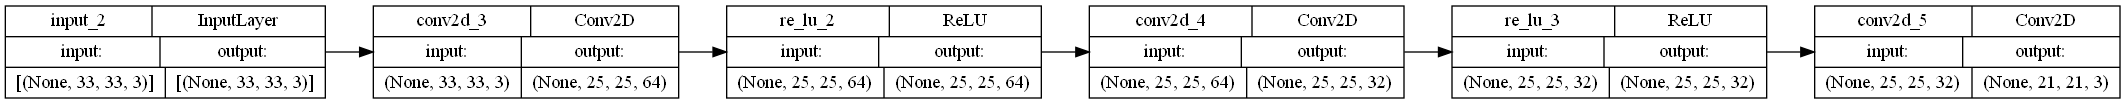

In [32]:
# Plot the model
tensorflow.keras.utils.plot_model(model, show_shapes = True, rankdir='LR')

In [33]:
# Save model weight
checkpoint_path = "../resources/training/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tensorflow.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, verbose=1)

### 2.3 Fitting the Model
Let's fit the model by setting the PatchesDataset parameter to 50 which mean total data / batch settings (50).

In [34]:
model.fit(PatchesDataset(50), epochs=EPOCHS, callbacks=[cp_callback])

Epoch 1/12
1/1 [==============================] - ETA: 0s - loss: 74704.5234
Epoch 1: saving model to ../resources/training\cp.ckpt
1/1 [==============================] - 1s 576ms/step - loss: 74704.5234
Epoch 2/12
1/1 [==============================] - ETA: 0s - loss: 10204.6299
Epoch 2: saving model to ../resources/training\cp.ckpt
1/1 [==============================] - 0s 173ms/step - loss: 10204.6299
Epoch 3/12
1/1 [==============================] - ETA: 0s - loss: 8073.1938
Epoch 3: saving model to ../resources/training\cp.ckpt
1/1 [==============================] - 0s 178ms/step - loss: 8073.1938
Epoch 4/12
1/1 [==============================] - ETA: 0s - loss: 19136.1484
Epoch 4: saving model to ../resources/training\cp.ckpt
1/1 [==============================] - 0s 200ms/step - loss: 19136.1484
Epoch 5/12
1/1 [==============================] - ETA: 0s - loss: 11979.0684
Epoch 5: saving model to ../resources/training\cp.ckpt
1/1 [==============================] - 0s 187ms/step -

## 2.4 Save the model to be deployed on the server

Not just only deploying it to server, but also you can just update the model state.

In [35]:
path = '../resources/suhu/shifu.h5'
model.save(path)

In [36]:
# Load the model
path = '../resources/suhu/shifu.h5'
model = tensorflow.keras.models.load_model(path)